[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmickevicius/mcwBiophysicsMriCourse/blob/main/rawDataReconPartialFourier.ipynb)

# Reconstruction Demo 

2D spoiled gradient recalled echo data were acquired in the spherical agar gel phantom using the 32 channel Nova RF coil. The data were acquired with a matrix size of 192x192, but, because we selected 'MINIMUM' for the echo time, only a little over half of k-space was acquired for each frequency encoding line. 

This demo will show how to reconstruct a usable 2D image from these undersampled data. 

In [9]:
import numpy as np 
import scipy.io as sio 
import matplotlib.pyplot as plt 

def fft1d(inp,dim):
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(inp,dim),axis=dim),dim)

def ifft1d(inp,dim):
    return np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(inp,dim),axis=dim),dim)

/tmp/ipykernel_23161/934024622.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(ksp[:,:,c])))


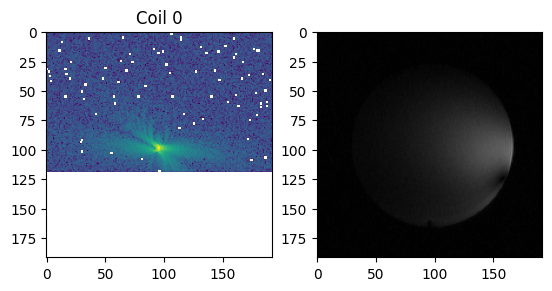

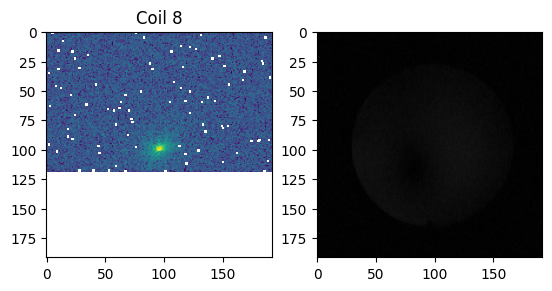

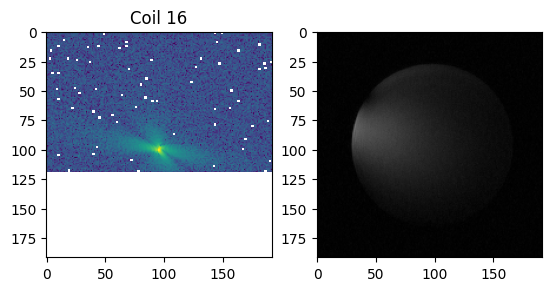

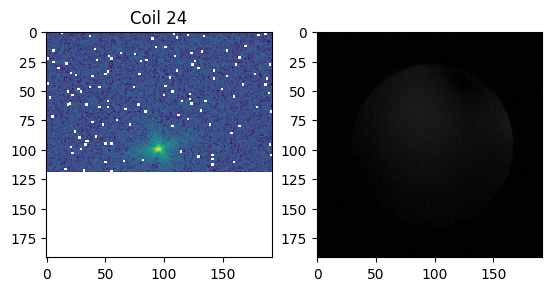

In [19]:
# load the complex-valued k-space stored in a .mat file 

# use this line if you are running this notebook locally
#ksp = sio.loadmat('data/ksp_20231012.mat')['ksp']

# use these lines if you are running in google colab
!wget https://github.com/nmickevicius/mcwBiophysicsMriCourse/blob/main/data/ksp_20231012.mat
ksp = sio.loadmat('/content/ksp_20231012.mat')

# by default, GE acquires data with a FOV/2 shift along phase encode dimension
# here we remove this shift by adding a phase of pi to every other line
ksp[:,::2,:] = ksp[:,::2,:] * np.exp(1j*np.pi)

# get coil images 
img = ifft1d(ifft1d(ksp,0),1)

# get some dimensions 
matrix = ksp.shape[0]
coils = ksp.shape[2]

# display k-space and image from a few coils 
# (logrithmic colorscale to show details away from k-space center)
# speckles in image are where k-space signal had such a small amplitude 
# that it was digitized to zero
for c in range(0,coils,8):
    fig = plt.figure()
    fig.add_subplot(121)
    plt.imshow(np.log10(np.abs(ksp[:,:,c])))
    plt.title('Coil %i'%c)
    fig.add_subplot(122)
    plt.imshow(np.abs(img[:,:,c]),cmap='gray',vmin=0.0,vmax=0.25*np.max(np.abs(img)))
    plt.show()

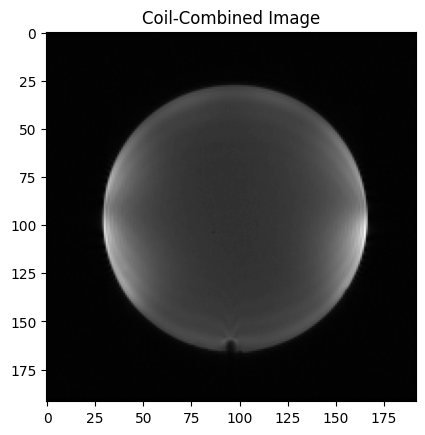

In [17]:
rss = np.abs(np.sqrt(np.sum(img * np.conj(img), axis=-1)))
plt.figure()
plt.imshow(rss,cmap='gray')
plt.title('Coil-Combined Image')
plt.show()

# Notice Anything? 

In the image above, the edges are not as sharp along the vertical direction. This is because we did not cover k-space fully along the frequency encoding direction. 

As discussed in class, we can fix this if we assume that the image is mostly real-valued, and we can leverage the conjugate symmetric property of the Fourier transform. 

To start, we need to get a low-resolution estimate of the image "background" phase. 

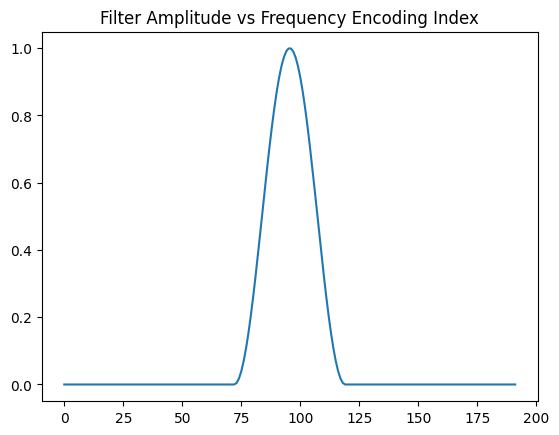

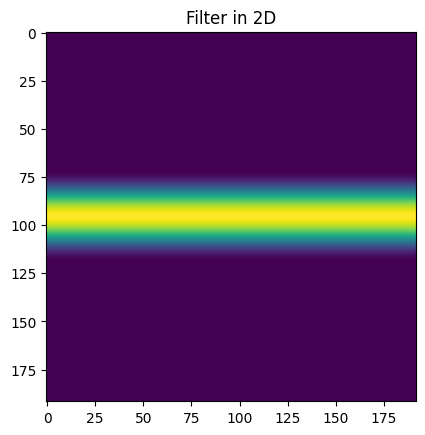

/tmp/ipykernel_23161/1559746693.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(fksp[:,:,cidx])))


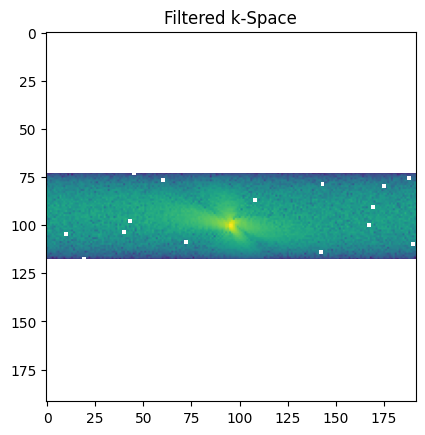

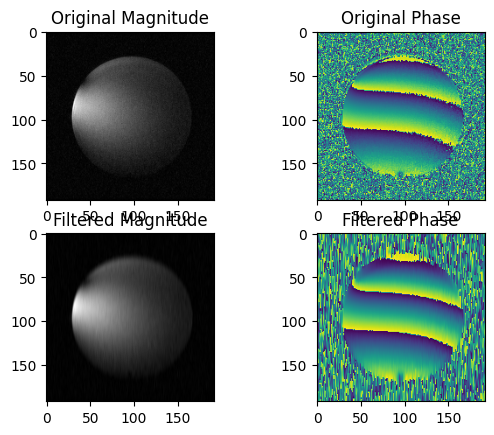

In [33]:
# this is the number of frequency encoding points that we actually acquired 
nx = 120 

# calculate how many lines past the center of k-space we have 
nover = int(2 * (nx - matrix/2))

# create a smoothly varying windowing function with this many samples 
filterSize = nover
i1 = int(matrix/2 - filterSize/2)
i2 = i1 + filterSize
filt = np.zeros((matrix,), dtype=np.float32)
filt[i1:i2] = np.hanning(filterSize)

# show the filter
plt.figure()
plt.plot(filt)
plt.title('Filter Amplitude vs Frequency Encoding Index')
plt.show()

# make the filter 2D
filt = np.stack([filt] * matrix, axis=-1)

# show the filter
plt.figure()
plt.imshow(filt)
plt.title('Filter in 2D')
plt.show()

# multiply k-space by this filter 
fksp = ksp * filt[...,None]

# coil index for plotting
cidx = 16

# show the filter
plt.figure()
plt.imshow(np.log10(np.abs(fksp[:,:,cidx])))
plt.title('Filtered k-Space')
plt.show()

# get low-resolution images 
lrimg = ifft1d(ifft1d(fksp,0),1)

# show magnitude and phase images 
fig = plt.figure()
fig.add_subplot(221)
plt.imshow(np.abs(img[:,:,cidx]),cmap='gray')
plt.title('Original Magnitude')
fig.add_subplot(223)
plt.imshow(np.abs(lrimg[:,:,cidx]),cmap='gray')
plt.title('Filtered Magnitude')
fig.add_subplot(222)
plt.imshow(np.angle(img[:,:,cidx]))
plt.title('Original Phase')
fig.add_subplot(224)
plt.imshow(np.angle(lrimg[:,:,cidx]))
plt.title('Filtered Phase')

# store the low-resolution phase
phase = np.exp(1j * np.angle(lrimg))


# Iterative Reconstruction 

Here we will use the iterative projection onto convex sets algorithm to restore the resolution that was lost along the frequency encoding dimension of the image 

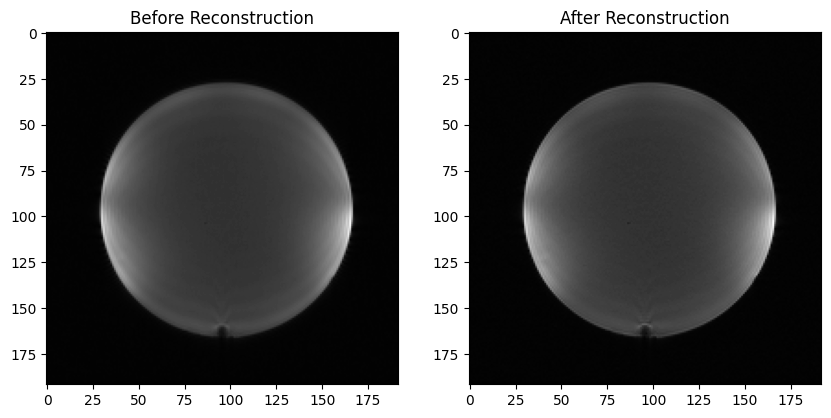

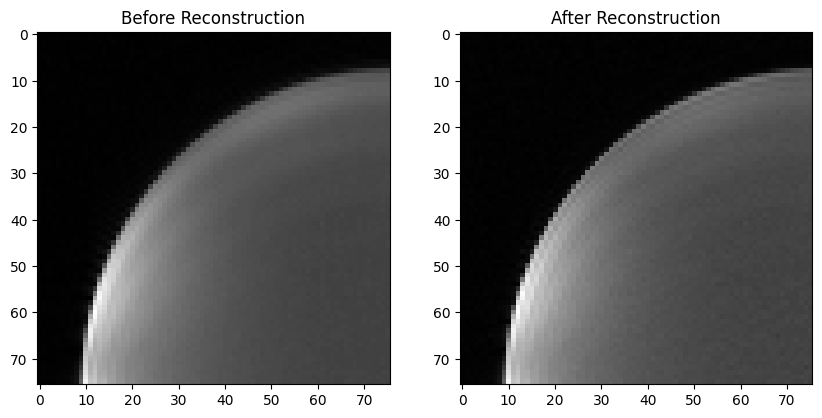

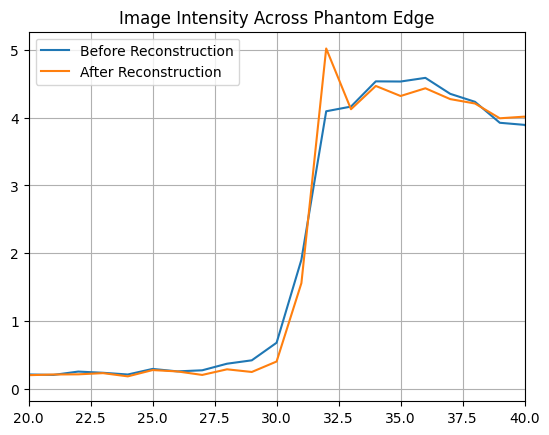

In [61]:

# hybrid image-k-space 
# (image domain along PE, k-space along FE)
hksp = ifft1d(ksp,1)

# intial guess for reconstruction 
recon = img

# loop over iterations 
for i in range(20):

    # multiply magnitude by low resolution phase 
    rho = np.abs(recon) * phase 

    # bring to k-space
    k = fft1d(rho,0)

    # put acquired samples back
    k[:nx,...] = hksp[:nx,...].copy() 

    # now bring back to image space 
    recon = ifft1d(k,0)


# combine coils 
recon_rss = np.abs(np.sqrt(np.sum(recon * np.conj(recon),-1)))

fig = plt.figure()
fig.set_figwidth(10)
fig.add_subplot(121)
plt.imshow(rss,cmap='gray')
plt.title('Before Reconstruction')
fig.add_subplot(122)
plt.imshow(recon_rss,cmap='gray')
plt.title('After Reconstruction')
plt.show()

fig = plt.figure()
fig.set_figwidth(10)
fig.add_subplot(121)
plt.imshow(rss[20:96,20:96],cmap='gray')
plt.title('Before Reconstruction')
fig.add_subplot(122)
plt.imshow(recon_rss[20:96,20:96],cmap='gray')
plt.title('After Reconstruction')
plt.show()

pidx = 75
plt.figure()
ax = plt.axes()
line1, = ax.plot(rss[:,pidx])
line1.set_label('Before Reconstruction')
line2, = ax.plot(recon_rss[:,pidx])
line2.set_label('After Reconstruction')
ax.legend()
plt.title('Image Intensity Across Phantom Edge')

plt.grid()
plt.xlim([20,40])
plt.show()





